In [17]:
import pandas as pd
#pre processamento
import re
import nltk
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#modelo
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import tensorflow as tf
#avalição
from sklearn.metrics import classification_report, confusion_matrix
#plot
from matplotlib import pyplot as plt
import seaborn as sns

In [18]:
#baixando pacotes necessários
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MGPFILH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MGPFILH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MGPFILH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Base de dados

In [19]:
#df = pd.read_csv('DATA/FakeNews.csv') #https://www.kaggle.com/datasets/algord/fake-news
#df = pd.read_csv('DATA/gossipcop_data.csv')
df = pd.read_csv('DATA/politifact_data.csv')
print(df.shape)
print(df.columns.values)
print(df['real'].value_counts())
df.head()
#1 real
#0 fake

(1056, 5)
['id' 'news_url' 'title' 'tweet_ids' 'real']
1    624
0    432
Name: real, dtype: int64


,id,news_url,title,tweet_ids,real
0,politifact695,http://www.msnbc.msn.com/id/26535811/,"Outlook, Office, Skype, Bing, Breaking News, a...",894937978\t357497238303408128\t104896144970224...,1
1,politifact914,NaN,Press release Rep Barton Democrats stimulus wi...,NaN,1
2,politifact14330,http://wazanews.tk/2017/07/13/breaking-someone...,ни чего нового как правильно,884788368923643905\t884788528672120832\t884789...,0
3,politifact13934,http://usleader.net/index.php/2017/05/05/break...,BREAKING: KEN STARR’S PLANE JUST DISAPPEARED O...,845338198159036417\t845338289024458752\t845340...,0
4,politifact15427,http://www.cvikas.com/2018/05/22/usa-mysteriou...,USA: Mysterious Nazi submarine from WWII disco...,700364228679565313\t700490720465948673\t700526...,0


Tratamento de dados

In [20]:
df.dropna(inplace=True) #removendo valores nulos
df.drop_duplicates(subset='title', keep='last', inplace=True) #removendo duplicatas
df.reset_index(drop=True, inplace=True)

def clean_text(text): 
    text = text.lower() #colocando em minúsculo
    return re.sub(r"[^A-Za-z0-9\s\.]", '', text) #removendo caracteres especiais

df['title'] = df['title'].apply(clean_text)
print(df.shape)
print(df['real'].value_counts())

(713, 5)
0    386
1    327
Name: real, dtype: int64


Balanceamento de carga

In [21]:
# df_fake = df[df['real'] == 0]
# df_real = df[df['real'] == 1]

# df_real_downsampled = resample(df_real, replace=False, n_samples=len(df_fake), random_state=42)
# df_balanced = pd.concat([df_real_downsampled, df_fake])
# df = df_balanced
# print(df_balanced.shape)
# print(df_balanced['real'].value_counts())

## PROCESSAMENTO DE LINGUAGEM NATURAL (PLN)

Tokenização, StopWords, Lematização

In [22]:
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = word_tokenize(text) #tokenização
    tokens = [token for token in tokens if token not in stop_words] #remoção de stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #lematização
    preprocessed_text = ' '.join(tokens) #junção de tokens
    
    return preprocessed_text

TF-IDF

In [23]:
def calculate_tfidf(text):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(text) #calculando TF-IDF
    return tfidf_matrix.toarray()

Aplicação do pré processamento

In [24]:
#aplicando tokenização, stopWords, lematização
df['tokens'] = df['title'].apply(preprocess)
#print(df['tokens'].head())

#calculando TF-IDF
X_balanced = calculate_tfidf(df['title']) 
print(type(X_balanced))
y_balanced = df['real']

<class 'numpy.ndarray'>


Divisão dos dados em treinamento e teste

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
#X_train, X_test -> pre processado
#y_train, y_test -> valores reais

## MODELOS ARTIFICIAIS

Naive Bayes

In [26]:
def naive_bayes_model(X_train, y_train, X_test):
    naive_bayes = MultinomialNB()
    naive_bayes.fit(X_train, y_train) #treinando modelo
    y_pred = naive_bayes.predict(X_test) #testando modelo
    return y_pred

Floresta Aleatória

In [27]:
def random_forest_model(X_train, y_train, X_test):
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train) #treinando modelo
    y_pred = random_forest.predict(X_test) #testando modelo
    return y_pred

Support Vector Machine

In [28]:
def support_vector_machine_model(X_train, y_train, X_test):
    svm = LinearSVC()
    svm.fit(X_train, y_train) #treinando modelo
    y_pred = svm.predict(X_test) #testando modelo
    return y_pred

Rede Neural

In [29]:
def neural_network_model(X_train, y_train, X_test):
    model = tf.keras.models.Sequential([ #definindo modelo
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #compilando modelo
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0) #treinando modelo
    y_pred = model.predict(X_test) #testando modelo
    y_pred = (y_pred > 0.5).astype(int) #convertendo valores para 0 ou 1
    
    return y_pred

Aplicação dos modelos

In [30]:
nb_model = naive_bayes_model(X_train, y_train, X_test)
rf_model = random_forest_model(X_train, y_train, X_test)
svm_model = support_vector_machine_model(X_train, y_train, X_test)
nn_model = neural_network_model(X_train, y_train, X_test)

5/5 [==============================] - 0s 3ms/step


## Métricas de Avaliação

Matriz de confusão

In [31]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.show()

Acurácia, precisão, recall, f1-score


#Naive Bayes:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84        78
           1       0.86      0.68      0.76        65

    accuracy                           0.80       143
   macro avg       0.82      0.79      0.80       143
weighted avg       0.81      0.80      0.80       143



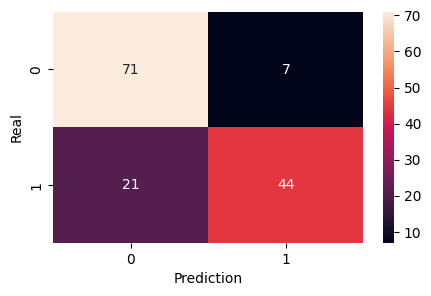


#Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.94      0.78        78
           1       0.85      0.45      0.59        65

    accuracy                           0.71       143
   macro avg       0.76      0.69      0.68       143
weighted avg       0.75      0.71      0.69       143



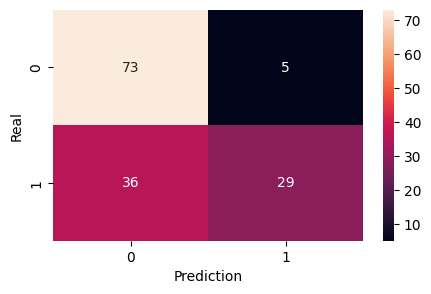


#Support Vector Machine:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83        78
           1       0.86      0.66      0.75        65

    accuracy                           0.80       143
   macro avg       0.81      0.79      0.79       143
weighted avg       0.81      0.80      0.79       143



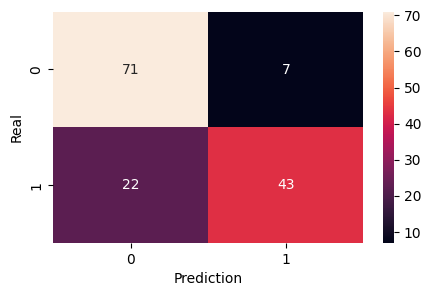


#Neural Network:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        78
           1       0.86      0.77      0.81        65

    accuracy                           0.84       143
   macro avg       0.84      0.83      0.84       143
weighted avg       0.84      0.84      0.84       143



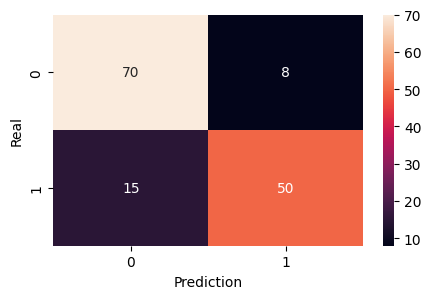

In [32]:
print("\n#Naive Bayes:\n", classification_report(y_test, nb_model))
plot_confusion_matrix(y_test, nb_model)
print("\n#Random Forest:\n", classification_report(y_test, rf_model))
plot_confusion_matrix(y_test, rf_model)
print("\n#Support Vector Machine:\n", classification_report(y_test, svm_model))
plot_confusion_matrix(y_test, svm_model)
print("\n#Neural Network:\n", classification_report(y_test, nn_model))
plot_confusion_matrix(y_test, nn_model)